In [39]:
from __future__ import division
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *
from risk_parity import *

# Purpose of the Notebook

Factor Risk Parity Portfolio Construction
1. Using Historical Covariance
 - Country
 - Cluster
 - Factor
2. DM Extension

In [40]:
country_etfs = pd.read_csv('../Data/country_data/ETF_adj_close.csv',index_col=0)
country_etfs.index = pd.to_datetime(country_etfs.index)
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)

In [41]:
# find weekly return - take last date and pct-change

country_returns = country_etfs.resample('W').last().pct_change()
# country_returns.index = country_returns.index.to_period('W')
equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')
equity_factors = equity_factors[equity_factors.momentum.notnull()]

clusters = pd.read_pickle('../Outputs/country_clusters/clusters_equity_etf_full.pkl')
clusters = clusters.groupby('cluster_label')['Countries'].apply(list).to_dict()
equity_clusters = []
for k in clusters.keys():
    ew_returns = country_returns[clusters[k]].mean(axis=1)
    equity_clusters.append(ew_returns)
equity_clusters = pd.concat(equity_clusters,axis=1)
equity_clusters = equity_clusters.loc[equity_factors.index]

# 1a. Country Risk Parity

In [57]:
cntry_level = country_returns.dropna()
equity_cntry_rp_rebal = HistCorrRebalance(aum=1, 
                                           asset_names=cntry_level.columns, 
                                           returns=cntry_level, 
                                           time=52, 
                                           target_vol=5, 
                                           lam_short=0.7, 
                                           lam_long=0.83, 
                                           burn=12, 
                                           barrier=1.5)

cntry_trade, cntry_trade_pct, cntry_weight, cntry_returns = equity_cntry_rp_rebal.get_flow()

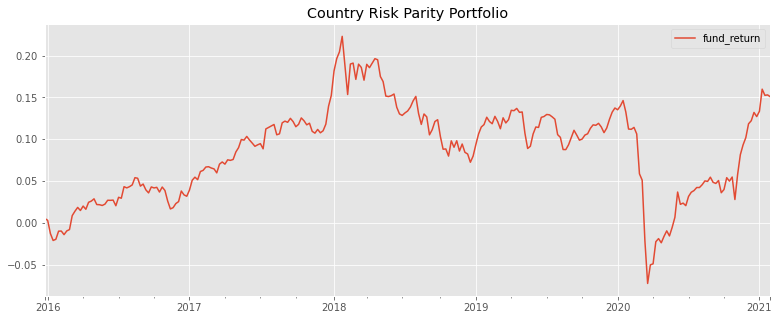

In [58]:
((1+cntry_returns).cumprod()-1).plot(figsize = (13,5),title = 'Country Risk Parity Portfolio');

# 1b. Cluster-Based Risk Parity

In [42]:
equity_clusters.columns = [f'Cluster_{i}' for i in range(4)]

In [43]:
equity_cluster_rp_rebal = HistCorrRebalance(aum=1, 
                                           asset_names=equity_clusters.columns, 
                                           returns=equity_clusters, 
                                           time=52, 
                                           target_vol=5, 
                                           lam_short=0.7, 
                                           lam_long=0.83, 
                                           burn=12, 
                                           barrier=1.5)

cluster_trade, cluster_trade_pct, cluster_weight, cluster_returns = equity_cluster_rp_rebal.get_flow()

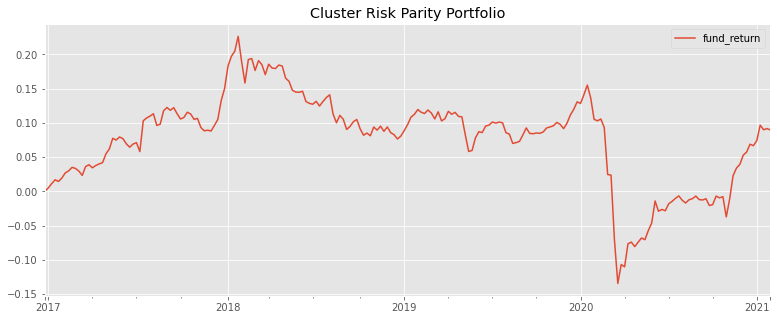

In [44]:
((1+cluster_returns).cumprod()-1).plot(figsize = (13,5),title = 'Cluster Risk Parity Portfolio');

# 1c. Factor-Based Risk Parity

In [45]:
factors_4_mkt= ['size', 'value', 'momentum', 'market-rf']

equity_f4mkt_rp_rebal = HistCorrRebalance(aum=1, 
                                           asset_names=factors_4_mkt, 
                                           returns=equity_factors[factors_4_mkt], 
                                           time=52, 
                                           target_vol=5, 
                                           lam_short=0.7, 
                                           lam_long=0.83, 
                                           burn=12, 
                                           barrier=1.5)

f4mkt_trade, f4mkt_trade_pct, f4mkt_weight, f4mkt_returns = equity_f4mkt_rp_rebal.get_flow()
# f4mkt_trade, f4mkt_trade_pct, f4mkt_weight, f4mkt_returns = equity_f4mkt_rp_rebal.get_flow(threshold_small=0.001, threshold_big=0.15)

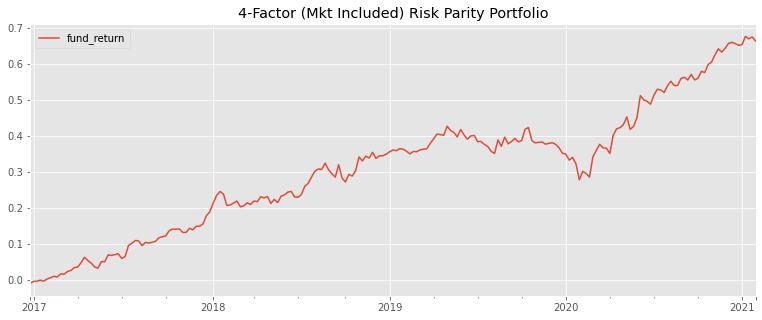

In [46]:
((1+f4mkt_returns).cumprod()-1).plot(figsize = (13,5),title = '4-Factor (Mkt Included) Risk Parity Portfolio');

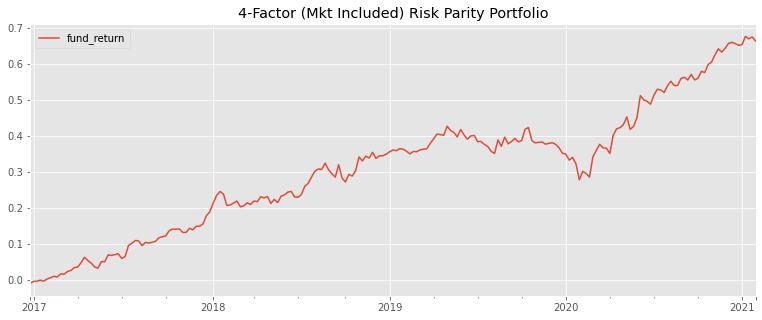

In [47]:
# 0.15 thresh big
((1+f4mkt_returns).cumprod()-1).plot(figsize = (13,5),title = '4-Factor (Mkt Included) Risk Parity Portfolio');

In [48]:
factors_4= ['size', 'value', 'momentum', 'low_beta']

equity_f4_rp_rebal = HistCorrRebalance(aum=1, 
                                       asset_names=factors_4, 
                                       returns=equity_factors[factors_4], 
                                       time=52, 
                                       target_vol=5, 
                                       lam_short=0.7, 
                                       lam_long=0.83, 
                                       burn=12, 
                                       barrier=1.5)

f4_trade, f4_trade_pct, f4_weight, f4_returns = equity_f4_rp_rebal.get_flow(threshold_small=0.001, threshold_big=0.15)

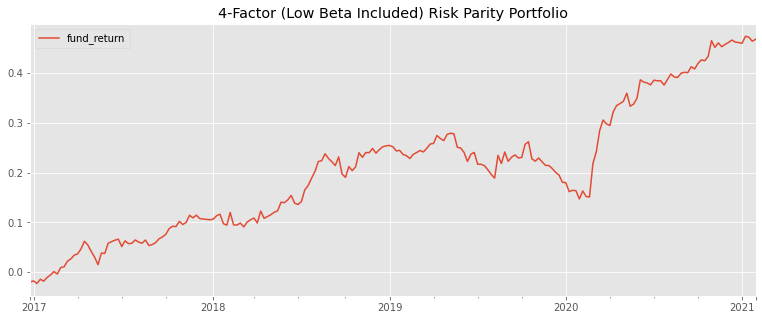

In [50]:
((1+f4_returns).cumprod()-1).plot(figsize = (13,5),title = '4-Factor (Low Beta Included) Risk Parity Portfolio');

In [51]:
factors_3= ['size', 'value', 'momentum']

equity_f3_rp_rebal = HistCorrRebalance(aum=1, 
                                       asset_names=factors_3, 
                                       returns=equity_factors[factors_3], 
                                       time=52, 
                                       target_vol=5, 
                                       lam_short=0.7, 
                                       lam_long=0.83, 
                                       burn=12, 
                                       barrier=1.5)

f3_trade, f3_trade_pct, f3_weight, f3_returns = equity_f3_rp_rebal.get_flow()

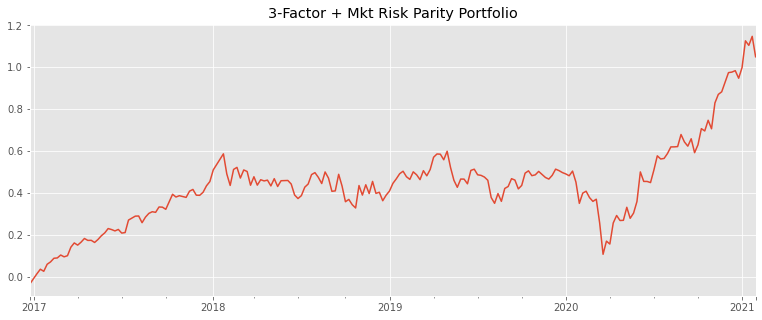

In [52]:
f3_mkt = pd.concat([f3_returns,equity_factors['market-rf']],axis=1).dropna()
f3_mkt['Combined'] = f3_mkt['fund_return'] + f3_mkt['market-rf']
((1+f3_mkt['Combined']).cumprod()-1).plot(figsize = (13,5),title = '3-Factor + Mkt Risk Parity Portfolio');

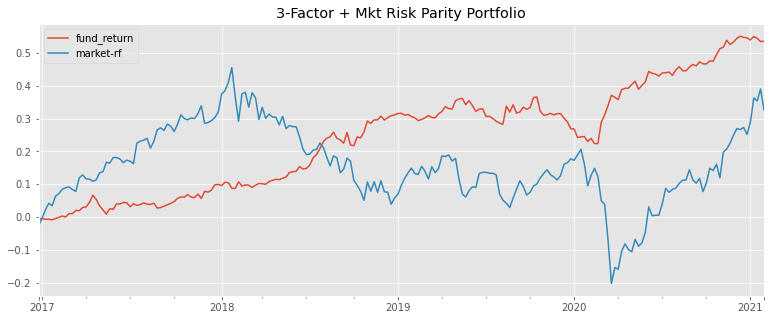

In [53]:
f3_mkt = pd.concat([f3_returns,equity_factors['market-rf']],axis=1).dropna()
((1+f3_mkt).cumprod()-1).plot(figsize = (13,5),title = '3-Factor + Mkt Risk Parity Portfolio');

## 2. Developed Markets Extension

In [61]:
dm_equity_factors = pd.read_pickle('../Outputs/equity/equity_DM_country_factors.pkl')

In [62]:
factors_4= ['size', 'value', 'momentum', 'low_beta']

dm_equity_f4_rp_rebal = HistCorrRebalance(aum=1, 
                                           asset_names=factors_4, 
                                           returns=dm_equity_factors[factors_4], 
                                           time=52, 
                                           target_vol=5, 
                                           lam_short=0.7, 
                                           lam_long=0.83, 
                                           burn=12, 
                                           barrier=1.5)

dm_f4_trade, dm_f4_trade_pct, dm_f4_weight, dm_f4_returns = dm_equity_f4_rp_rebal.get_flow()

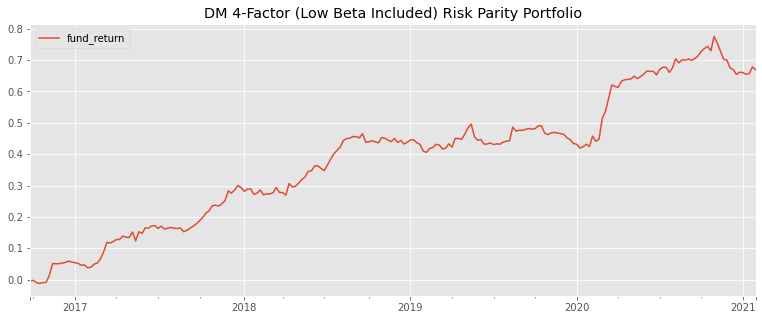

In [64]:
((1+dm_f4_returns.dropna()).cumprod()-1).plot(figsize = (13,5),
                                              title = 'DM 4-Factor (Low Beta Included) Risk Parity Portfolio');

In [65]:
factors_3= ['size', 'value', 'momentum']

dm_equity_f3_rp_rebal = HistCorrRebalance(aum=1, 
                                       asset_names=factors_3, 
                                       returns=dm_equity_factors[factors_3], 
                                       time=52, 
                                       target_vol=5, 
                                       lam_short=0.7, 
                                       lam_long=0.83, 
                                       burn=12, 
                                       barrier=1.5)

dm_f3_trade, dm_f3_trade_pct, dm_f3_weight, dm_f3_returns = dm_equity_f3_rp_rebal.get_flow()

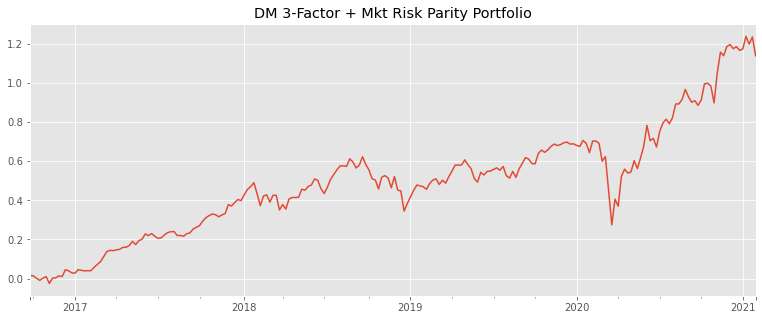

In [69]:
dm_f3_mkt = pd.concat([dm_f3_returns,dm_equity_factors['Mkt-RF']],axis=1).dropna()
dm_f3_mkt['Combined'] = dm_f3_mkt['fund_return'] + dm_f3_mkt['Mkt-RF']
((1+dm_f3_mkt['Combined']).cumprod()-1).plot(figsize = (13,5),title = 'DM 3-Factor + Mkt Risk Parity Portfolio');

# Comparison

In [77]:
portfolios = [cntry_returns, cluster_returns, 
              f4mkt_returns,f4_returns,f3_returns,
              dm_f4_returns, dm_f3_returns]
all_rp = pd.concat(portfolios,axis=1)
all_rp.columns = ['Country', 'Cluster',
                 '4-Factor (Mkt)','4-Factor (BAB)','3-Factor+Mkt',
                 'DM 4-Factor (BAB)','DM 3-Factor+Mkt']

perf_df = {}
for c in all_rp:
    res = calc_performance(all_rp[c], log_ret = False, time = 52)
    perf_df[c] = res

dfidx = ['Ann Return','Ann Std','Ann SR',
         'Skewness','Kurtosis','Max Drawdown','Max DD Date']
perf_df = pd.DataFrame(perf_df, index = dfidx)
perf_df

,Country,Cluster,4-Factor (Mkt),4-Factor (BAB),3-Factor+Mkt,DM 4-Factor (BAB),DM 3-Factor+Mkt
Ann Return,2.77,2.1,13.08,9.72,10.94,12.4,10.31
Ann Std,7.91,10.14,7.95,7.77,7.7,7.06,6.73
Ann SR,0.35,0.21,1.65,1.25,1.42,1.76,1.53
Skewness,-1.62,-2.24,0.33,0.75,0.54,0.79,0.96
Kurtosis,9.34,14.1,1.92,3.61,3.02,2.48,3.87
Max Drawdown,24.14,29.4,10.44,10.33,10.45,6.84,5.57
Max DD Date,2020-03-22,2020-03-22,2020-02-02,2020-02-02,2020-02-23,2020-12-20,2020-01-12


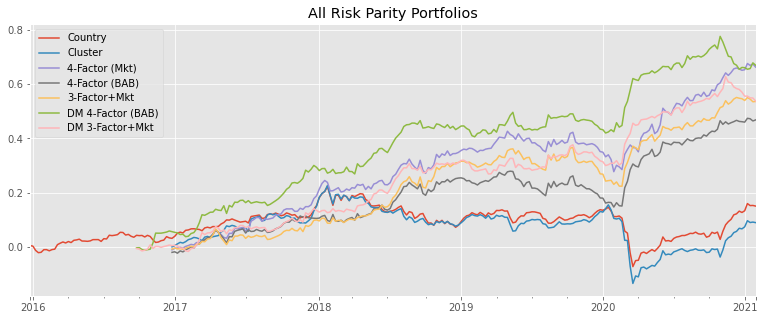

In [79]:
((1+all_rp).cumprod()-1).plot(figsize=(13,5), title = 'All Risk Parity Portfolios');